Alright we are going to try and detect brain tumors. First we load pytorch, torchvision and some other libraries we need.

In [36]:
from transformers import AutoFeatureExtractor, ResNetForImageClassification
import torch
from torchvision import datasets,transforms
import torchvision
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

Next we are going to load and transform our dataset. Here is what's important. I've resized and centered mine to 128x128. All you data and images need to be in the same size. You can do other things here like change the greyscale or cut out some colors. This is going to be a key to tuning this model, is figuring out the optimal normization for the images. Changing these sizes will require small changes to our model as well.

We load a test and train set. We need to train and validate and they can't be the same. We also need to our labels for the data.

In [37]:

transform = transforms.Compose([transforms.Resize(128),
                                 transforms.CenterCrop(128),
                                 transforms.ToTensor()])
training_dataset = datasets.ImageFolder('archive/Training', transform=transform)
testing_dataset = datasets.ImageFolder('archive/Testing', transform=transform)

# Class labels
classes = ('glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor')

We are going to load our training and test data and pick our batch size. Batch size is an important hyper parameter that will affect how fast our gradient descent converges or if it will at all. In our case this is 4 images at a time.

In [38]:
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=4, shuffle=False)

The below code allows us to see the images from our training set and validate their labels.

pituitary_tumor  pituitary_tumor  no_tumor  glioma_tumor


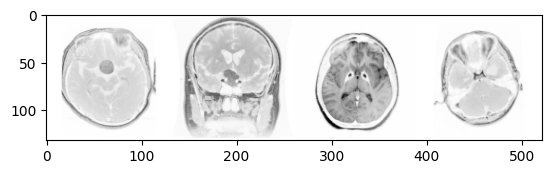

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

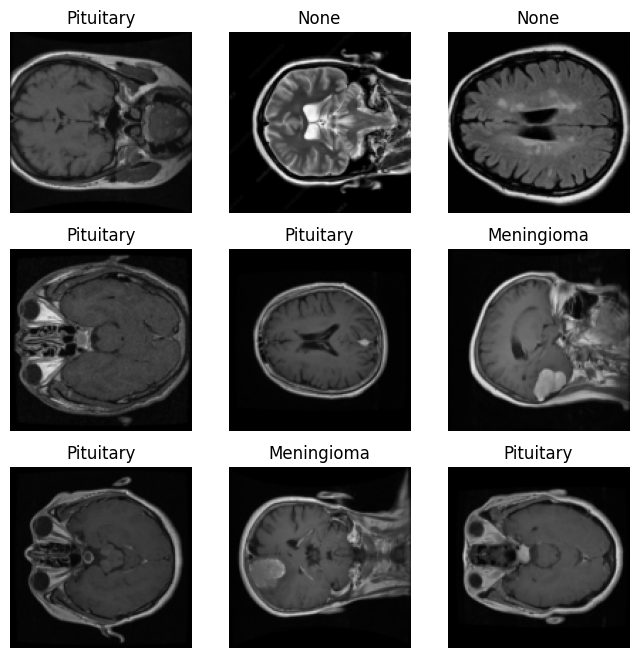

In [40]:
labels_map = {
    0: "Glioma",
    1: "Meningioma",
    2: "None",
    3: "Pituitary"
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_dataset), size=(1,)).item()
    img, label = training_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.T, cmap="gray")
plt.show()

Ok we are going to seperate our images into batches and displays their labels.

In [41]:
for batch_number, (images, labels) in enumerate(training_loader):
    print(batch_number, labels)

0 tensor([2, 2, 0, 2])
1 tensor([1, 0, 1, 0])
2 tensor([0, 0, 1, 1])
3 tensor([3, 0, 1, 3])
4 tensor([1, 0, 1, 0])
5 tensor([2, 0, 1, 0])
6 tensor([3, 2, 3, 3])
7 tensor([3, 3, 1, 2])
8 tensor([0, 2, 1, 0])
9 tensor([0, 3, 1, 1])
10 tensor([2, 2, 0, 1])
11 tensor([0, 0, 0, 0])
12 tensor([1, 0, 0, 3])
13 tensor([0, 2, 0, 2])
14 tensor([0, 1, 2, 0])
15 tensor([3, 3, 2, 3])
16 tensor([0, 0, 3, 3])
17 tensor([0, 0, 1, 2])
18 tensor([2, 0, 3, 3])
19 tensor([1, 0, 0, 1])
20 tensor([1, 1, 1, 2])
21 tensor([1, 0, 3, 0])
22 tensor([0, 3, 2, 3])
23 tensor([0, 0, 3, 3])
24 tensor([0, 0, 2, 1])
25 tensor([0, 3, 0, 1])
26 tensor([1, 0, 0, 1])
27 tensor([3, 1, 3, 0])
28 tensor([0, 2, 2, 2])
29 tensor([1, 0, 0, 0])
30 tensor([3, 1, 3, 0])
31 tensor([3, 3, 0, 1])
32 tensor([3, 0, 1, 1])
33 tensor([1, 3, 1, 1])
34 tensor([1, 1, 0, 1])
35 tensor([1, 3, 3, 0])
36 tensor([0, 1, 0, 3])
37 tensor([1, 0, 0, 0])
38 tensor([1, 3, 1, 0])
39 tensor([1, 3, 3, 2])
40 tensor([1, 0, 3, 1])
41 tensor([3, 1, 1, 0])
42

In [42]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [43]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class TumorClassifier(nn.Module):
    def __init__(self):
        super(TumorClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4*56*56,120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = TumorClassifier()

In [44]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(2, 4)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 3])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.7303, 0.7227, 0.2568, 0.5362],
        [0.6840, 0.3315, 0.2963, 0.0574]])
tensor([1, 3])
Total loss for this batch: 1.4697750806808472


In [45]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(training_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = 'model_{}'.format(timestamp)
torch.save(model.state_dict(), model_path)

[1,   200] loss: 1.814
[1,   400] loss: 1.351
[1,   600] loss: 1.197
[2,   200] loss: 0.968
[2,   400] loss: 0.884
[2,   600] loss: 0.833
[3,   200] loss: 0.709
[3,   400] loss: 0.730
[3,   600] loss: 0.697
[4,   200] loss: 0.637
[4,   400] loss: 0.582
[4,   600] loss: 0.538
[5,   200] loss: 0.513
[5,   400] loss: 0.480
[5,   600] loss: 0.466
[6,   200] loss: 0.370
[6,   400] loss: 0.372
[6,   600] loss: 0.439
[7,   200] loss: 0.319
[7,   400] loss: 0.310
[7,   600] loss: 0.330
[8,   200] loss: 0.268
[8,   400] loss: 0.238
[8,   600] loss: 0.252
[9,   200] loss: 0.240
[9,   400] loss: 0.212
[9,   600] loss: 0.190
[10,   200] loss: 0.230
[10,   400] loss: 0.146
[10,   600] loss: 0.159
Finished Training


def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss


    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

pituitary_tumor  no_tumor  meningioma_tumor  no_tumor


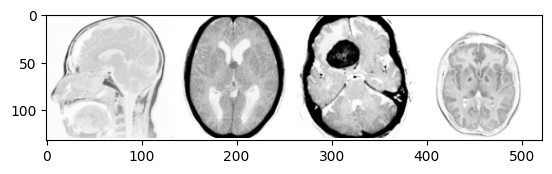

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(validation_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [33]:
net = TumorClassifier()
net.load_state_dict(torch.load(model_path, weights_only=True))
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  pituitary_tumor no_tumor meningioma_tumor no_tumor


In [35]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 68 %
